In [1]:
# import data transformation
import duckdb
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkb

# viz
from keplergl import KeplerGl
from IPython.display import IFrame
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
duckdb.sql('INSTALL spatial')
duckdb.sql('LOAD spatial')

## Import data

### 👮 Crimes

#### Table description

In [ ]:
query = """
DESCRIBE TABLE 'data/Crimes.csv';
"""

duckdb.sql(query)

In [ ]:
query = """
SUMMARIZE TABLE 'data/Crimes.csv';
"""

duckdb.sql(query)

#### Count Null values

In [215]:
query = """
SELECT 
    SUM(CASE WHEN Location IS NULL THEN 1 ELSE 0 END) AS count_nulls
    , COUNT(Location) AS tot_values
    , count_nulls/tot_values*100 AS percent 
FROM 'data/Crimes.csv';
"""

duckdb.sql(query)

┌─────────────┬────────────┬────────────────────┐
│ count_nulls │ tot_values │      percent       │
│   int128    │   int64    │       double       │
├─────────────┼────────────┼────────────────────┤
│       89945 │    8082689 │ 1.1128103530891762 │
└─────────────┴────────────┴────────────────────┘

In [ ]:
query = """
SELECT COUNT(ID) AS count, Year
FROM 'data/Crimes.csv'
WHERE Location IS NULL
GROUP BY Year
ORDER BY Year DESC;
"""

df = duckdb.sql(query).df()
px.bar(df, x='Year', y='count', width=800, height=800)

#### Create Crimes table

In [ ]:
query = """
CREATE OR REPLACE TABLE crimes AS
SELECT * FROM 'data/Crimes.csv'
WHERE Location IS NOT NULL;
"""

duckdb.sql(query)

In [4]:
query = """
ALTER TABLE crimes 
ADD COLUMN geometry GEOMETRY;
UPDATE crimes
SET geometry = ST_Point2D(Longitude, Latitude);
"""

duckdb.sql(query)

In [5]:
query = """
SELECT COUNT(*) FROM crimes;
"""

duckdb.sql(query)

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      8082689 │
└──────────────┘

### 🍱 Commnity Areas

In [39]:
query = """
SELECT
    layers[1].geometry_fields[1].crs.auth_name as name,
    layers[1].geometry_fields[1].crs.auth_code as code
FROM st_read_meta('data/Com_Areas.geojson');
"""

duckdb.sql(query)

┌─────────┬─────────┐
│  name   │  code   │
│ varchar │ varchar │
├─────────┼─────────┤
│ EPSG    │ 4326    │
└─────────┴─────────┘

In [9]:
query = """
CREATE OR REPLACE TABLE com_areas AS
SELECT * FROM ST_Read('data/Com_Areas.geojson');
ALTER TABLE com_areas 
RENAME COLUMN geom to geometry;
"""

duckdb.sql(query)

In [41]:
query = """
DESCRIBE com_areas;
"""

duckdb.sql(query)

┌─────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│ column_name │ column_type │  null   │   key   │ default │  extra  │
│   varchar   │   varchar   │ varchar │ varchar │ varchar │ varchar │
├─────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ community   │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ area        │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ shape_area  │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ perimeter   │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ area_num_1  │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ area_numbe  │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ comarea_id  │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ comarea     │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ shape_len   │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ geometry    │ GEOMETRY    │ YES     │ NULL    │ NULL    │ NULL    │
├─────────────┴─────

## First Exploration: Global statistics

#### 😱 Q1-2 Which is the most dangerous year in Chicago? (more crimes reported?)

In [6]:
# Most dangerous year

query = """
SELECT Year, COUNT(*) as count 
FROM crimes 
GROUP BY Year 
ORDER BY count DESC 
LIMIT 1;
"""

duckdb.sql(query)

┌───────┬────────┐
│ Year  │ count  │
│ int64 │ int64  │
├───────┼────────┤
│  2001 │ 482878 │
└───────┴────────┘

In [ ]:
# number of crimes by year

query = """
SELECT Year, COUNT(*) AS nb FROM crimes WHERE Year <> 2024 GROUP BY Year;
"""

df = duckdb.sql(query).df()
df.set_index('Year').plot(kind='bar', y='nb')

In [ ]:
# let's make it interactive with plotly 

fig = px.bar(df, x='Year', y='nb', width=800, height=500)
fig.show()

#### ⏰ Q3 What is most dangerous hours of the day?

In [ ]:
# hours of the day

query = """
SELECT strftime('%H', Date) AS hour, count(ID) AS nb
FROM crimes 
GROUP BY hour
ORDER BY hour ASC;
"""

df = duckdb.sql(query).df()
px.bar(df, x='hour', y='nb', width=800, height=800)

#### 📅 Q3 What is most dangerous day of week?

In [ ]:
# reported crimes per week day

query = """
SELECT strftime('%A', Date) AS day, count(ID) AS nb 
FROM crimes 
GROUP BY day
"""

df = duckdb.sql(query).df()
cats= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df= df.set_index('day').reindex(cats).reset_index()
px.bar(df, x='day', y='nb', width=800, height=800)

#### 🎄 Q4 How many crimes have been committed for NYE?

In [ ]:
# reported crimes at midnight on the 01.01 of each year

query = """
SELECT Year, count(ID) as nb 
FROM crimes 
WHERE strftime('%Y-%m-%d %H:%M:%S', Date) == strftime('%Y-01-01 00:00:00', Date)
GROUP BY Year;
"""

df = duckdb.sql(query).df()
px.bar(df, x='Year', y='nb', width=800, height=800)

In [16]:
query = """
SELECT count(ID)
FROM crimes 
WHERE strftime('%Y-%m-%d %H:%M:%S', Date) == strftime('%Y-01-01 00:00:00', Date)
"""
duckdb.sql(query)

┌───────────┐
│ count(ID) │
│   int64   │
├───────────┤
│      2455 │
└───────────┘

#### 😒 Q5 What is the most common crime that end up in an arrest?

In [ ]:
# number of crimes by types

query = """
SELECT "Primary Type" AS type, COUNT(ID) AS count
FROM crimes 
WHERE Arrest IS TRUE
GROUP BY "Primary Type"
ORDER BY count DESC;
"""

df = duckdb.sql(query).df()
px.bar(df, x='type', y='count', width=800, height=800)

In [29]:
# Most arrested crime by year

query = """
WITH crime_count AS (
  SELECT "Primary Type" AS type, 
         COUNT(ID) AS count, 
         Year
  FROM crimes 
  WHERE Arrest IS TRUE
  GROUP BY "Primary Type", Year
),
max_counts AS (
  SELECT Year,
         MAX(count) as max_count
  FROM crime_count
  GROUP BY Year
)
SELECT cc.type, 
       cc.count,
       cc.Year
FROM crime_count cc
JOIN max_counts mc 
  ON cc.Year = mc.Year 
  AND cc.count = mc.max_count
ORDER BY cc.Year DESC;
"""

duckdb.sql(query).show(max_rows=100)

┌───────────┬───────┬───────┐
│   type    │ count │ Year  │
│  varchar  │ int64 │ int64 │
├───────────┼───────┼───────┤
│ BATTERY   │  5739 │  2024 │
│ BATTERY   │  6941 │  2023 │
│ BATTERY   │  5933 │  2022 │
│ BATTERY   │  5765 │  2021 │
│ NARCOTICS │  7265 │  2020 │
│ NARCOTICS │ 14991 │  2019 │
│ NARCOTICS │ 12791 │  2018 │
│ NARCOTICS │ 11469 │  2017 │
│ NARCOTICS │ 13251 │  2016 │
│ NARCOTICS │ 21599 │  2015 │
│ NARCOTICS │ 28790 │  2014 │
│ NARCOTICS │ 33801 │  2013 │
│ NARCOTICS │ 35213 │  2012 │
│ NARCOTICS │ 38524 │  2011 │
│ NARCOTICS │ 43290 │  2010 │
│ NARCOTICS │ 41917 │  2009 │
│ NARCOTICS │ 44266 │  2008 │
│ NARCOTICS │ 53210 │  2007 │
│ NARCOTICS │ 54763 │  2006 │
│ NARCOTICS │ 55845 │  2005 │
│ NARCOTICS │ 56859 │  2004 │
│ NARCOTICS │ 53758 │  2003 │
│ NARCOTICS │ 49816 │  2002 │
│ NARCOTICS │ 50310 │  2001 │
├───────────┴───────┴───────┤
│ 24 rows         3 columns │
└───────────────────────────┘



#### 📈 Q6 Trends for the most comment crime over the years

In [ ]:
# number of crimes by types

query = """
SELECT "Primary Type" AS type, Year, COUNT(ID) AS count 
FROM crimes 
GROUP BY "Primary Type", Year
ORDER BY Year DESC;
"""

df = duckdb.sql(query).df()
px.line(df, x='Year', y='count', color="type", width=900, height=800)

#### 🚓  Q7 Most typical crime per community areas

In [18]:
query = """
SELECT community, "Primary Type", crime_count FROM (
    SELECT 
        ca.community
        , ca.area_numbe
        , c."Primary Type"
        , COUNT(c.ID) as crime_count
        , ROW_NUMBER() OVER (PARTITION BY ca.area_numbe ORDER BY COUNT(c.ID) DESC) as rn
    FROM crimes c
    JOIN com_areas ca ON c."Community Area" = ca.area_numbe
    WHERE c.Year=2023
    GROUP BY 
        ca.community
        , ca.area_numbe
        , c."Primary Type"
        , ca.geometry
) ranked
WHERE rn = 1;
"""

# Fetching the data into a pandas DataFrame
duckdb.sql(query).show(max_rows=100)

┌────────────────────────┬─────────────────────┬─────────────┐
│       community        │    Primary Type     │ crime_count │
│        varchar         │       varchar       │    int64    │
├────────────────────────┼─────────────────────┼─────────────┤
│ NEW CITY               │ BATTERY             │         872 │
│ GREATER GRAND CROSSING │ BATTERY             │        1393 │
│ NORWOOD PARK           │ THEFT               │         328 │
│ AVONDALE               │ THEFT               │         669 │
│ EAST GARFIELD PARK     │ BATTERY             │         881 │
│ NORTH LAWNDALE         │ BATTERY             │        1604 │
│ SOUTH SHORE            │ BATTERY             │        1760 │
│ BURNSIDE               │ MOTOR VEHICLE THEFT │          49 │
│ ENGLEWOOD              │ BATTERY             │        1146 │
│ AVALON PARK            │ BATTERY             │         190 │
│ CHICAGO LAWN           │ BATTERY             │        1058 │
│ GARFIELD RIDGE         │ THEFT               │       

In [ ]:
query = """
SELECT * FROM (
    SELECT 
        ca.community
        , ca.area_numbe
        , c."Primary Type"
        , COUNT(c.ID) as crime_count
        , ROW_NUMBER() OVER (PARTITION BY ca.area_numbe ORDER BY COUNT(c.ID) DESC) as rn
        , ST_AsHexWKB(ca.geometry) AS geometry
    FROM crimes c
    JOIN com_areas ca ON c."Community Area" = ca.area_numbe
    WHERE c.Year=2023
    GROUP BY 
        ca.community
        , ca.area_numbe
        , c."Primary Type"
        , ca.geometry
) ranked
WHERE rn = 1;
"""

# Fetching the data into a pandas DataFrame
df_crimes_comarea = duckdb.sql(query).df()

# Convert pandas DataFrame to GeoDataFrame
gdf_crimes_comarea = gpd.GeoDataFrame(
    df_crimes_comarea, geometry=gpd.GeoSeries.from_wkb(df_crimes_comarea['geometry']), crs="EPSG:4326"
)

fig = px.choropleth_map(gdf_crimes_comarea, geojson=gdf_crimes_comarea['geometry'], 
                           locations=gdf_crimes_comarea.index, color=gdf_crimes_comarea['Primary Type'], 
                            hover_data=['community', 'area_numbe', 'crime_count'], color_continuous_scale="agsunset",
                           zoom=10, center={"lat": 41.8781, "lon": -87.6298}, 
                           labels={'crime_count': 'Crimes Count'}, height= 1000,
                            map_style="dark"
                          )
fig.show()

#### 🍱 Q8 Number of crimes per community areas

In [10]:
query = """
SELECT ca.community, count(c.ID) AS count
FROM crimes c
JOIN com_areas ca ON 
    c."Community Area" = ca.area_numbe
GROUP BY ca.community
ORDER BY count;
"""

# Fetching the data into a pandas DataFrame
duckdb.sql(query).show(max_rows=100)

┌────────────────────────┬────────┐
│       community        │ count  │
│        varchar         │ int64  │
├────────────────────────┼────────┤
│ EDISON PARK            │   7473 │
│ BURNSIDE               │  11113 │
│ FOREST GLEN            │  13950 │
│ MOUNT GREENWOOD        │  16733 │
│ HEGEWISCH              │  16908 │
│ OAKLAND                │  17623 │
│ MONTCLARE              │  17914 │
│ FULLER PARK            │  24684 │
│ NORTH PARK             │  25356 │
│ ARCHER HEIGHTS         │  27071 │
│ BEVERLY                │  27168 │
│ ARMOUR SQUARE          │  28553 │
│ WEST ELSDON            │  28858 │
│ CLEARING               │  29931 │
│ JEFFERSON PARK         │  29969 │
│ MCKINLEY PARK          │  30342 │
│ PULLMAN                │  30353 │
│ NORWOOD PARK           │  32824 │
│ RIVERDALE              │  33931 │
│ EAST SIDE              │  37155 │
│ AVALON PARK            │  38066 │
│ CALUMET HEIGHTS        │  40919 │
│ NORTH CENTER           │  43923 │
│ KENWOOD                │  

In [11]:
query = """
SELECT ca.community, ca.area_numbe, count(c.ID) AS count, ST_AsHexWKB(ca.geometry) AS geometry
FROM crimes c
JOIN com_areas ca ON 
    c."Community Area" = ca.area_numbe
GROUP BY ca.area_numbe, ca.community, ca.geometry
"""

# Fetching the data into a pandas DataFrame
df_crimes_count = duckdb.sql(query).df()

# Convert pandas DataFrame to GeoDataFrame
gdf_crimes_count = gpd.GeoDataFrame(
    df_crimes_count, geometry=gpd.GeoSeries.from_wkb(df_crimes_count['geometry']), crs="EPSG:4326"
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

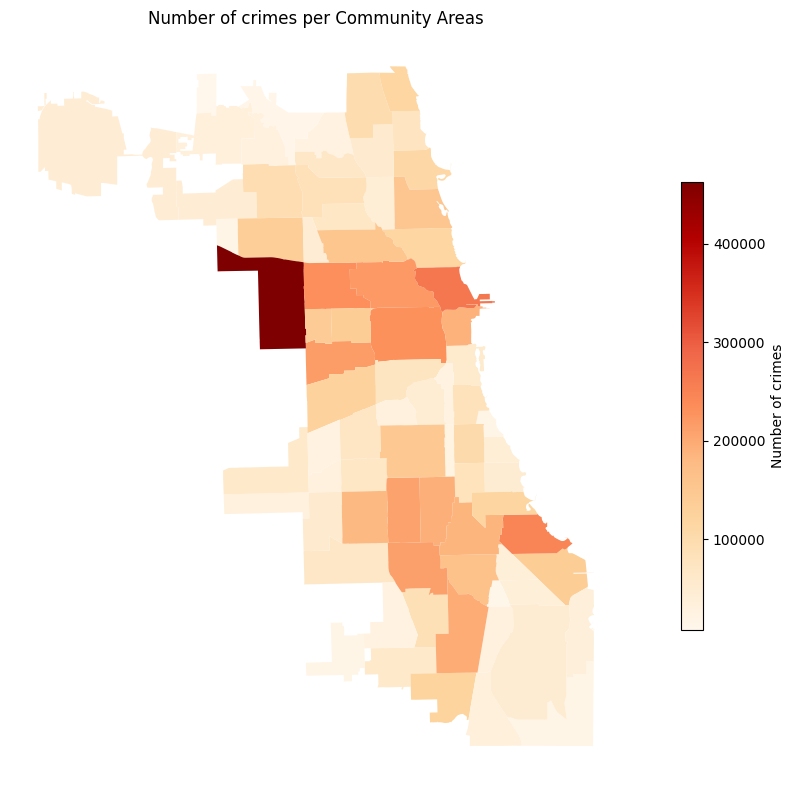

In [12]:
# Matplotlib visualization

# Plotting the result
fig, ax = plt.subplots(figsize=(12, 8))
gdf_crimes_count.plot(
    column='count',
    cmap='OrRd',  # Optional: colour scheme

    legend=True,
    ax=ax,
    legend_kwds={'label': "Number of crimes", 'shrink': 0.6}
)

# Setting plot titles and labels
ax.set_title('Number of crimes per Community Areas')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Optional: turn off axis visibility
ax.axis('off')

# Ensure layout is properly adjusted
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
fig = px.choropleth_map(gdf_crimes_count, geojson=gdf_crimes_count['geometry'], 
                           locations=gdf_crimes_count.index, color='count', 
                            hover_data=['community', 'area_numbe'], color_continuous_scale="agsunset",
                           zoom=10, center={"lat": 41.8781, "lon": -87.6298}, 
                           labels={'count': 'Crimes Count'}, height= 1000,
                            map_style="dark"
                          )
fig.show()

In [ ]:
# create an interactive map with Kepler

# create map 
kepler_map = KeplerGl()
# center the map on the data
kepler_map.config['mapState'] = {
            'latitude': gdf_crimes_count.iloc[0].geometry.centroid.y,
            'longitude': gdf_crimes_count.iloc[0].geometry.centroid.x,
            'zoom': 10
}

# Add data to the map
kepler_map.add_data(data= gdf_crimes_count, name='crimes')

# save to html
kepler_map.save_to_html(file_name='explore_map.html', config=kepler_map.config)

# Visualize the map in a div
IFrame(src='./explore_map.html', width=800, height=800)

#### 🎨 Q9 Random sample per type of crimes - crimes distribution and data animation

In [152]:
query = """
SELECT strftime('%Y-%m-%d %H:%M:%S', Date) as date, Year, cr.ID, "Primary Type" AS type, cr.Latitude, cr.Longitude, ST_AsHEXWKB(cr.geometry) AS geometry
FROM crimes cr
    TABLESAMPLE(5 percent)
JOIN com_areas ca ON 
    ST_WITHIN(cr.geometry, ca.geometry)
"""

# Fetching the data into a pandas DataFrame
df_crimes_type_overall = duckdb.sql(query).df()

# Convert pandas DataFrame to GeoDataFrame
gdf_crimes_type_overall = gpd.GeoDataFrame(
    df_crimes_type_overall, geometry=gpd.GeoSeries.from_wkb(df_crimes_type_overall['geometry']), crs="EPSG:4326"
)

gdf_crimes_type_overall.count()

date         379240
Year         379240
ID           379240
type         379240
Latitude     379240
Longitude    379240
geometry     379240
dtype: int64

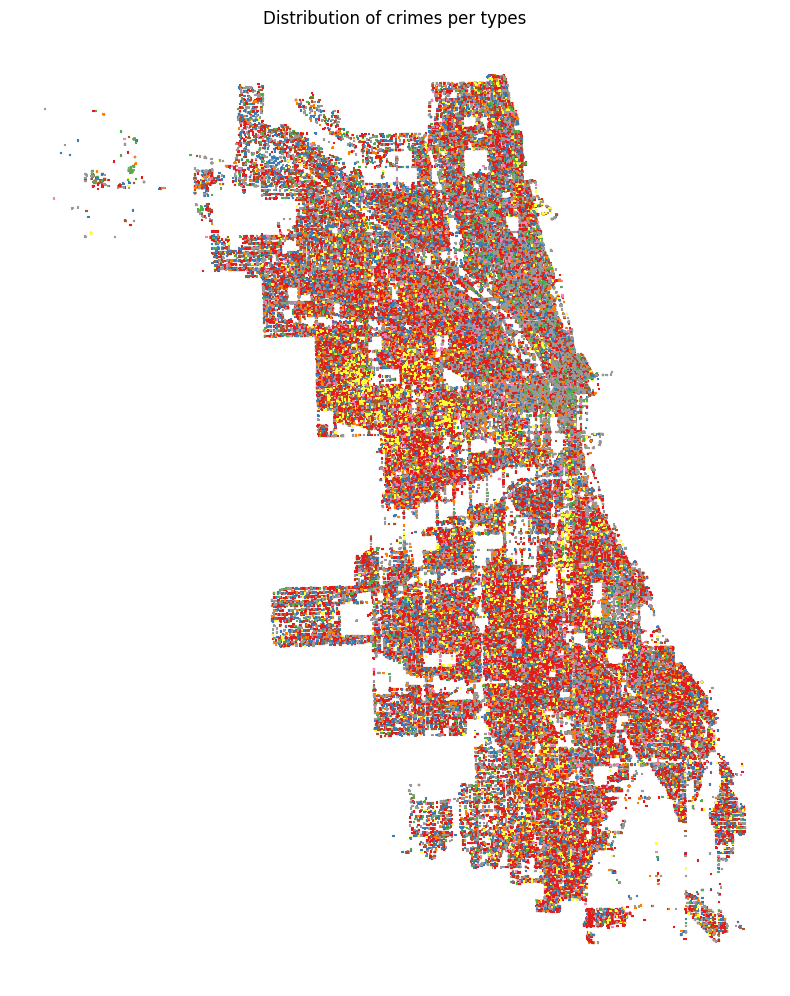

In [34]:
# Converting the WKB geometries to shapely geometries

fig, ax = plt.subplots(figsize=(8, 12))

gdf_crimes_type_overall.plot(
    ax=ax,
    column='type',       # Column to use for colouring the plot
    cmap='Set1',         # A qualitative colour map suitable for categories
    markersize=3,        # Size of the markers (applies to point geometries)
    legend=False,         # Show a legend
    categorical=True,    # Treat the 'type' column as categorical data
    marker='+',
)

# Setting plot titles and labels
ax.set_title('Distribution of crimes per types')

# Optional: turn off axis visibility
ax.axis('off')

# Ensure layout is properly adjusted
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# create an interactive map with Kepler

# create map 
kepler_map = KeplerGl()
# center the map on the data
kepler_map.config['mapState'] = {
            'latitude': gdf_crimes_type_overall.iloc[0].geometry.centroid.y,
            'longitude': gdf_crimes_type_overall.iloc[0].geometry.centroid.x,
            'zoom': 10
}

# add data to the map
kepler_map.add_data(data= gdf_crimes_type_overall, name='crimes')

# save to html
kepler_map.save_to_html(file_name='explore_map.html', config=kepler_map.config)

# Visualize the map in a div
IFrame(src='./explore_map.html', width=1200, height=800)

## Density Analysis

#### 🌶️  Q10 HeatMap KDE

In [148]:
def kde_plot(df: gpd.GeoDataFrame, ax, title: str, lon: str='Longitude', lat: str='Latitude', grid_size: int=100, vmax=100 ):
    """
    Plots a kernel density estimate (KDE) of point data from a DataFrame anchored in a figure

    Parameters:
        gdf : geopandas.GeoDataFrame
            GeoDataFrame containing the point geometries.
        ax : matplotlib.axes.Axes
            Matplotlib axes on which to plot.
        title : str
            Title of the plot.
        lon : str, optional
            Column longitude in the df.
        lat : str, optional
            Column latitude in the df.
        grid_size : complex or int, optional
            Grid size for the KDE calculation. Defaults to 100
        vmax : int, optional
            max value of the density - range of the legend
    """
    # apply a gaussian KDE to the coordinates of the df 
    # we need to transpose the coordinates to have one row with Longitude values and one row with Latitude values
    kde = gaussian_kde(df[[lon, lat]].T)
    
    # create a grid to plot the KDE values
    # the grid goes from min to max in grid_size steps
    x_steps = np.linspace(df[lon].min(), df[lon].max(), grid_size)
    y_steps = np.linspace(df[lat].min(), df[lat].max(), grid_size) 
    # create a 2D grid of x and y coordinates
    x_grid, y_grid = np.meshgrid(x_steps, y_steps)
    # ravel() flattens each grid array into a 1D array
    # np.vstack stacks these 1D arrays so that each column represents a coordinate pair
    grid = np.vstack([x_grid.ravel(), y_grid.ravel()])

    # calculate the density scores on the grid
    Z_score = kde(grid).reshape(x_grid.shape)

    # create a filled contour graph based on the grid and density score
    countour = ax.contourf(x_grid, y_grid, Z_score, cmap='viridis', vmin=0, vmax=vmax)
    # add contour lines to emphasize the density gradient
    ax.contour(x_grid, y_grid, Z_score, levels=10, colors='black', linewidths=0.2, vmin=0, vmax=60)

    # customize plot
    ax.set_title(title)
    ax.set_xlabel(lon)
    ax.set_ylabel(lat)
    # add a colour bar
    plt.colorbar(countour, ax=ax, label='Density')

In [127]:
# Get the NACROTICS type for YEARs 2001, 2012, 2023
query = """
SELECT cr.ID, cr."Primary Type" AS type, cr.Latitude, cr.Longitude, cr.Year
FROM crimes cr
JOIN com_areas ca ON 
    ST_WITHIN(cr.geometry, ca.geometry)
WHERE cr."Primary Type" = 'NARCOTICS'
    AND cr.Year in (2001,2012,2023)
"""    
# Fetch data and convert to GeoDataFrame
df_crimes = duckdb.sql(query).df()

In [135]:
# Get community areas geometries to print the border 
query = """
SELECT ca.community, ca.area_numbe, ST_AsHexWKB(ca.geometry) AS geometry
FROM com_areas ca;
"""

# Fetching the data into a pandas DataFrame
df_ca = duckdb.sql(query).df()

# Convert pandas DataFrame to GeoDataFrame
gdf_ca = gpd.GeoDataFrame(
    df_ca, geometry=gpd.GeoSeries.from_wkb(df_ca['geometry']), crs="EPSG:4326"
)

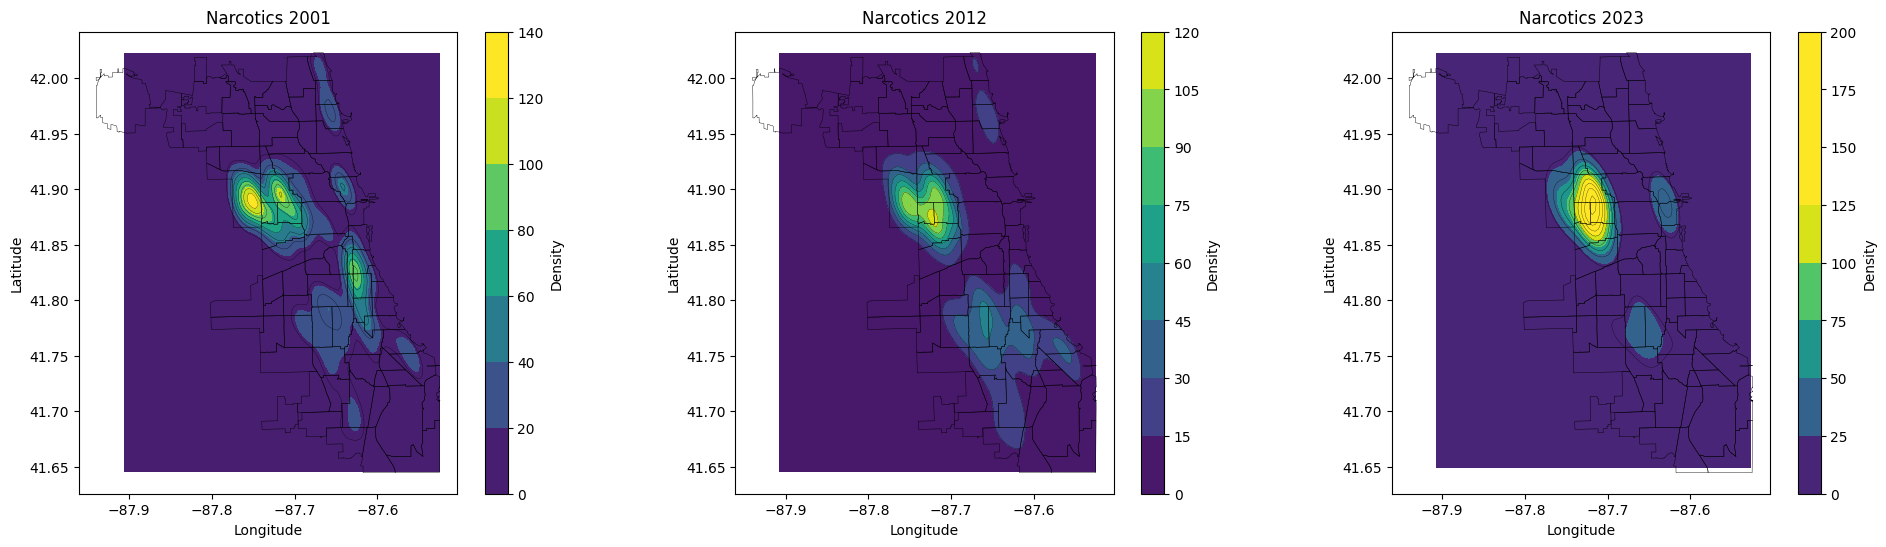

In [149]:
# create the kde of the 3 years next to each others
# plot the KDE
fig, ax = plt.subplots(1, 3, figsize=(24, 6))

# 2001
kde_plot(df_crimes.query("Year == 2001").reset_index(), ax[0], 'Narcotics 2001', vmax = 120)
# add limits of community areas if defined
gdf_ca.plot(ax=ax[0], facecolor='none', edgecolor='black', linewidths=0.3)

# 2012
kde_plot(df_crimes.query("Year == 2012"), ax[1], 'Narcotics 2012', vmax = 120)
# add limits of community areas if defined
gdf_ca.plot(ax=ax[1], facecolor='none', edgecolor='black', linewidths=0.3)

# 2023
kde_plot(df_crimes.query("Year == 2023"), ax[2], 'Narcotics 2023', vmax = 120)
# add limits of community areas if defined
gdf_ca.plot(ax=ax[2], facecolor='none', edgecolor='black', linewidths=0.3)

plt.show()

In [ ]:
query = """
SELECT cr.ID, Description AS type, Year, cr.Latitude, cr.Longitude, ST_AsHEXWKB(cr.geometry) AS geometry
FROM crimes cr
JOIN com_areas ca ON 
    ST_WITHIN(cr.geometry, ca.geometry)
WHERE "Primary Type" = 'THEFT' and Description LIKE '%500%' 
"""

# Fetching the data into a pandas DataFrame
df_theft = duckdb.sql(query).df()

# Convert pandas DataFrame to GeoDataFrame
gdf_theft = gpd.GeoDataFrame(
    df_theft, geometry=gpd.GeoSeries.from_wkb(df_theft['geometry']), crs="EPSG:4326"
)

px.density_heatmap(df_theft, x="Longitude", y="Latitude", facet_row="type", marginal_y="histogram", height=1200)